<a href="https://colab.research.google.com/github/JunLee1422/CBNU_2023254019_/blob/main/Apprentice%20project/apprentice_project_crops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 작물정보.xls to 작물정보.xls
데이터 집합의 형태 (행, 열): (2200, 9)
데이터 집합의 처음 10개 행:
   Nitrogen  Phosphorus  Potassium  Temperature   Humidity        pH  \
0        90          42         43    20.879744  82.002744  6.502985   
1        85          58         41    21.770462  80.319644  7.038096   
2        60          55         44    23.004459  82.320763  7.840207   
3        74          35         40    26.491096  80.158363  6.980401   
4        78          42         42    20.130175  81.604873  7.628473   
5        69          37         42    23.058049  83.370118  7.073454   
6        69          55         38    22.708838  82.639414  5.700806   
7        94          53         40    20.277744  82.894086  5.718627   
8        89          54         38    24.515881  83.535216  6.685346   
9        68          58         38    23.223974  83.033227  6.336254   

     Rainfall label    Rate  
0  202.935536  rice  0.3448  
1  226.655537  rice  0.2323  
2  263.964248  rice  0.8211  
3  242.86403

interactive(children=(Dropdown(description='crop', options=('rice', 'maize', 'chickpea', 'kidneybeans', 'pigeo…

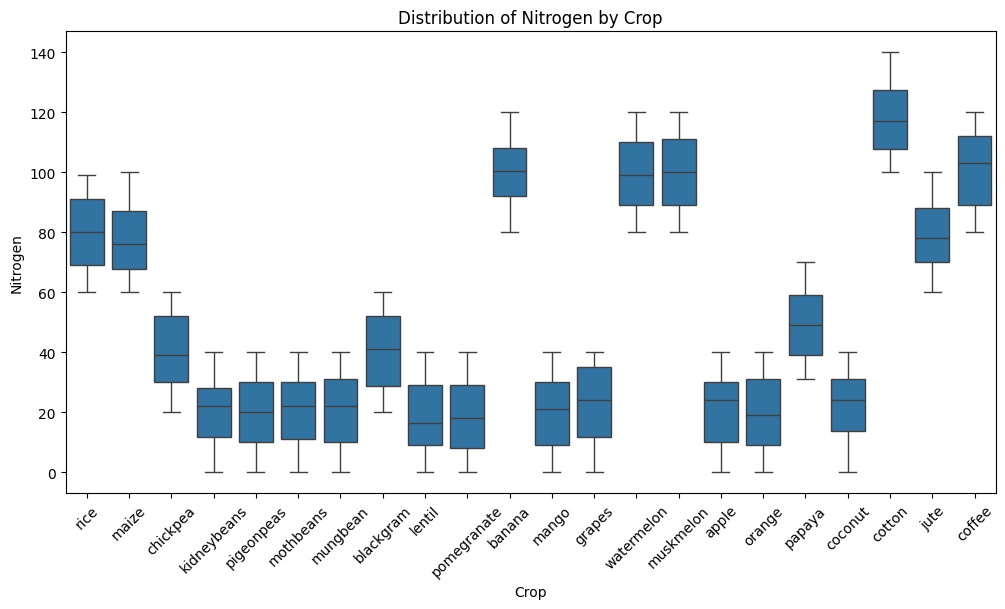

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from ipywidgets import interact
from google.colab import files

# 파일 업로드
uploaded = files.upload()

# 업로드한 파일 이름 입력
file_name = '작물정보.xls'

# 데이터 불러오기
data = pd.read_excel(file_name)

# 열 이름 수정
data.columns = ['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH', 'Rainfall', 'label', 'Rate']

# 기본 폰트 설정
plt.rcdefaults()

# 데이터 집합의 형태 출력
print("데이터 집합의 형태 (행, 열):", data.shape)

# 데이터 집합의 처음 10개 행 출력
print("데이터 집합의 처음 10개 행:")
print(data.head(10))

# 데이터 집합에서 누락된 값 확인
missing_values = data.isnull().sum()
print("데이터 집합에서 누락된 값:")
print(missing_values)

# 토양 내 농업 매개 변수(Nitrogen, Phosphorus, Potassium, Temperature, Humidity, pH, Rainfall)의 평균 계산
mean_values = data[['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH', 'Rainfall']].mean()
print("농업 매개 변수의 평균값:")
print(mean_values)

# Rate 변수 추가
data['Rate'] = np.random.uniform(0.01, 0.99, size=len(data))

# 계절별 작물 분석
def classify_season(temperature, humidity):
    if temperature > 32 and humidity > 50:
        return "여름 작물"
    elif temperature < 20 and humidity > 32:
        return "겨울 작물"
    elif humidity > 32:
        return "비절기 작물"
    else:
        return "기타"

data['Season'] = data.apply(lambda x: classify_season(x['Temperature'], x['Humidity']), axis=1)
seasonal_crops = data[['label', 'Season']]
print("계절별 작물 분류:")
print(seasonal_crops)

# Rate 변수 추가
data['Rate'] = np.random.uniform(0.01, 0.99, size=len(data))

# 예측 모델을 위한 데이터 준비
X = data[['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH', 'Rainfall']]
y = data['Rate']

# 학습 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge 회귀 모델 초기화
model = Ridge()

# 탐색할 alpha 값의 후보 목록
param_grid = {'alpha': [0.1, 1, 10, 100]}

# Grid Search 객체 생성
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 모델 확인
best_alpha = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best alpha: {best_alpha}")
print(f"Best model: {best_model}")

# 모델 평가
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("평균 제곱 오차 (MSE):", mse)

# 최적 환경 조건 및 예상 생산량 예측 함수
def predict_optimal_conditions(crop, condition, value):
    # Copy the data for the selected crop
    crop_data = data[data['label'] == crop].copy()
    # Update the selected condition with the user-input value
    crop_data[condition] = value
    # Predict the rate (production) for the updated crop data
    rate = best_model.predict(crop_data[['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH', 'Rainfall']])
    return rate[0]  # Return the predicted rate

# 사용자 인터페이스: 작물, 조건, 값 선택하여 생산률 예측
@interact
def show_optimal_conditions(crop=data['label'].unique(), condition=['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'pH', 'Humidity', 'Rainfall'], value=(0, 100)):
    print(f"Predicted optimal conditions and rate for crop: {crop}")
    predicted_rate = predict_optimal_conditions(crop, condition, value)
    print(f"Condition: {condition}, Value: {value}, Predicted Rate: {predicted_rate:.2f}")

# 조건 분포 시각화
condition_to_visualize = 'Nitrogen'
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y=condition_to_visualize, data=data)
plt.title(f'Distribution of {condition_to_visualize} by Crop')
plt.xticks(rotation=45)
plt.xlabel('Crop')
plt.ylabel(condition_to_visualize)
plt.show()
